## Before we do any analysis, we need to combine some data from all of our datasets. Run the following block first to generate the final tables that you will need. 

In [1]:
###
# Before we do any analysis, the table needs to be adjusted to put in all the data that we need for analysis. 
###

from astropy.table import Table, unique, vstack, hstack
from matplotlib.pyplot import *
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np

print('Initializing')

## The name of the file that comes from x-ray analysis and after relevant cuts are made. 
## Currently, the match table is listed, but the correct file will be needed in the future. 
main = Table.read('match_table.fits')
main.sort('RA')

## Generated from the Checking Sources tab
mem = Table.read('catalog_members_relevant.fits')
mem.sort('RA')

AGN = Table.read('table_Y3_unique.csv')

## Things to add
main['Z'] = np.zeros(len(main['RA']))
main['P'] = np.zeros(len(main['RA']))
main['MEM_MATCH_ID'] = np.zeros(len(main['RA']),dtype=int)
main['LAMBDA_CHISQ'] = np.zeros(len(main['RA']))
main['Count'] = np.arange(0,len(main))
main['AGN_Candidate'] = np.zeros(len(main['RA']),dtype=bool)

print('Sorting by RA and Dec')

## Sorts by RA and Dec
X = SkyCoord(ra=main['RA']*u.degree, dec=main['DEC']*u.degree)
catalog = SkyCoord(ra=mem['RA']*u.degree, dec=mem['DEC']*u.degree)

idxx, d2d, d3d = X.match_to_catalog_sky(catalog)

## Assigns values based on RA and Dec
for count in np.arange(0,len(idxx)):

    relation_index = idxx[count]
    main['Z'][count] = mem['Z'][relation_index]
    main['P'][count] = mem['P'][relation_index]
    main['MEM_MATCH_ID'][count] = mem['MEM_MATCH_ID'][relation_index]
print('Done (1 of 3)')

print('Sorting by MEM_MATCH_ID')
## Sorts by MEM MATCH ID        
xsorted = np.argsort(AGN['MEM_MATCH_ID'])
ypos = np.searchsorted(AGN['MEM_MATCH_ID'][xsorted], main['MEM_MATCH_ID'])
indices = xsorted[ypos]

## Assigns values based on MEM MATCH ID
for count in np.arange(0,len(idxx)):
    main['LAMBDA_CHISQ'][count] = AGN['LAMBDA_CHISQ'][indices[count]]
print('Done (2 of 3)')
print('Sorting for AGN')
    
i=0
for ra_gal in AGN['Galaxy RA']:
    dummy = main[main['RA']<ra_gal+0.0000001]
    dummy = dummy[dummy['RA']>ra_gal-0.0000001]
    
    for count in dummy['Count']:
        main['AGN_Candidate'][count] = True
    i+=1
    if i%100==0:
        print(str(round(i*100.0/len(AGN)))+'%')
    
print('Done (3 of 3). Finalizing')
main.write('Full_Analysis_Table.fits',overwrite=True)

main.sort('time')
main.reverse()
main = unique(main,keys=('RA','DEC'))
main.sort('obsid')

main.write('Unique_Analysis_Table.fits',overwrite=True)

print('All Done')

Initializing
Sorting by RA and Dec
Done (1 of 3)
Sorting by MEM_MATCH_ID
Done (2 of 3)
Sorting for AGN
16%
33%
49%
66%
82%
99%
Done (3 of 3). Finalizing
All Done


### By the end you will have two files. One is the full table with no cuts and the other is only unique RA and Dec values prioritized by longest exposure time. 

### Now you have to choose which file to use. Edit the file name below

In [2]:
working_file = Table.read('Unique_Analysis_Table.fits')

### Now we are going to seperate the following by what analysis we want. Remember that you can change the number of bins you want in each bit of code near the top

### Histograms of Richness and Redshift

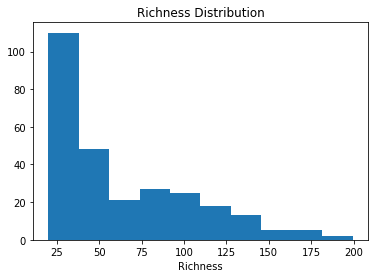

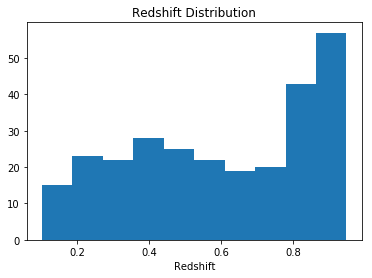

In [3]:
hist(unique(working_file,keys='MEM_MATCH_ID')['LAMBDA_CHISQ'],bins='auto')
xlabel('Richness')
title('Richness Distribution')
show()
hist(unique(working_file,keys='MEM_MATCH_ID')['Z'],bins='auto')
xlabel('Redshift')
title('Redshift Distribution')
show()

### Richness with no cuts on redshift

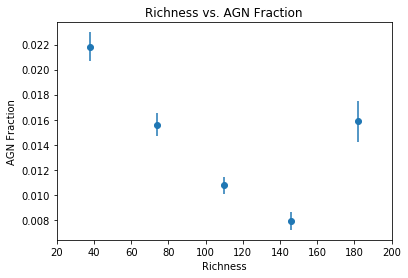

Left Lambda,Right Lambda,AGN Fraction,Number AGN,Number Other,Number Clusters,AGN_Frac_Sigma
float64,float64,float64,int32,int32,int32,float64
20.0,56.0,0.021825763203294175,209,8731,158,0.0011631648843072574
56.0,92.0,0.015607942107789166,101,5288,49,0.0009249152079602494
92.0,128.0,0.010746392046630944,80,6402,42,0.0006708876181250207
128.0,164.0,0.0079173673107812,42,3854,19,0.0007303740907956261
164.0,200.0,0.01586618891724432,25,1291,6,0.00165403413793426


In [4]:
## Begining initialization
startpoint = 20.0
endpoint = 200.0

## Here is where you can change the number of bins
number_of_bins = 5

spacing = (endpoint-startpoint)/number_of_bins
fraction = Table(names=('Left Lambda','Right Lambda','AGN Fraction','Number AGN','Number Other','Number Clusters','AGN_Frac_Sigma'), dtype=('f8','f8','f8','i4','i4','i4','f8'))

## If you want to impose cuts on the data, here is where you would impose them 
h = working_file

agn = h[h['AGN_Candidate']] #AGN candidates
ee = h[h['AGN_Candidate']!=True] #Everything else

turn = startpoint + spacing

while turn <= endpoint:
    
    ee_turn = ee[ee['LAMBDA_CHISQ']>turn-spacing]
    ee_turn = ee_turn[ee_turn['LAMBDA_CHISQ']<turn]
    
    agn_turn = agn[agn['LAMBDA_CHISQ']>turn-spacing]
    agn_turn = agn_turn[agn_turn['LAMBDA_CHISQ']<turn]
    
    agn_fraction = np.sum(agn_turn['P'])/(np.sum(agn_turn['P'])+np.sum(ee_turn['P']))
    
    ## We assume an error from the standard deviation of a bernouli distrubution
    error_agn = (np.sum(agn_turn['P']*(1-agn_turn['P'])))**(0.5)
    error_all = (np.sum(agn_turn['P']*(1-agn_turn['P']))+np.sum(ee_turn['P']*(1-ee_turn['P'])))**(0.5)
    
    ## Standard error propogation on independent variables (which may not actually be appropriate)
    frac_error = (error_agn**2/(np.sum(agn_turn['P'])+np.sum(ee_turn['P']))**2+(np.sum(agn_turn['P'])*error_all/(np.sum(agn_turn['P'])+np.sum(ee_turn['P']))**2)**2)**(0.5)
    
    fraction.add_row([round(turn-spacing,4),round(turn,4),agn_fraction,len(agn_turn),len(ee_turn),len(unique(ee_turn,keys='MEM_MATCH_ID')),frac_error])
    turn+=spacing
## Plotting stuff
L = (fraction['Left Lambda']+fraction['Right Lambda'])/2.0
errorbar(L,fraction['AGN Fraction'],marker='o',yerr=fraction['AGN_Frac_Sigma'],ls='None')
xlim(startpoint,endpoint)
xlabel('Richness')
ylabel('AGN Fraction')
title('Richness vs. AGN Fraction')
# savefig('Richness_AGN_high.png')
show()
# fraction.write('Richness_AGN_high.csv',overwrite=True)
fraction

### Richness with a z>0.6 cut

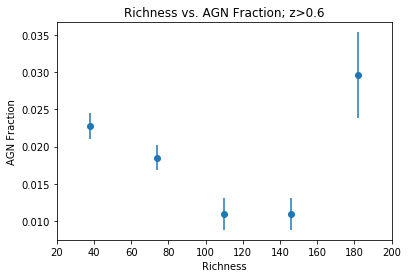

Left Lambda,Right Lambda,AGN Fraction,Number AGN,Number Other,Number Clusters,AGN_Frac_Sigma
float64,float64,float64,int32,int32,int32,float64
20.0,56.0,0.022804105564574278,143,5836,103,0.0017730873198064014
56.0,92.0,0.018522830311155845,62,2718,23,0.0017121557162990161
92.0,128.0,0.010943013868218521,19,1347,8,0.0021492151298568084
128.0,164.0,0.010921623331589171,13,944,4,0.002117017607625222
164.0,200.0,0.02958747832730125,15,373,2,0.005792217783130367


In [5]:
## Begining initialization
startpoint = 20.0
endpoint = 200.0

## Here is where you can change the number of bins
number_of_bins = 5

spacing = (endpoint-startpoint)/number_of_bins
fraction = Table(names=('Left Lambda','Right Lambda','AGN Fraction','Number AGN','Number Other','Number Clusters','AGN_Frac_Sigma'), dtype=('f8','f8','f8','i4','i4','i4','f8'))

## If you want to impose cuts on the data, here is where you would impose them 
h = working_file[working_file['Z']>0.6]

agn = h[h['AGN_Candidate']] #AGN candidates
ee = h[h['AGN_Candidate']!=True] #Everything else

turn = startpoint + spacing

while turn <= endpoint:
    
    ee_turn = ee[ee['LAMBDA_CHISQ']>turn-spacing]
    ee_turn = ee_turn[ee_turn['LAMBDA_CHISQ']<turn]
    
    agn_turn = agn[agn['LAMBDA_CHISQ']>turn-spacing]
    agn_turn = agn_turn[agn_turn['LAMBDA_CHISQ']<turn]
    
    agn_fraction = np.sum(agn_turn['P'])/(np.sum(agn_turn['P'])+np.sum(ee_turn['P']))
    
    ## We assume an error from the standard deviation of a bernouli distrubution
    error_agn = (np.sum(agn_turn['P']*(1-agn_turn['P'])))**(0.5)
    error_all = (np.sum(agn_turn['P']*(1-agn_turn['P']))+np.sum(ee_turn['P']*(1-ee_turn['P'])))**(0.5)
    
    ## Standard error propogation on independent variables (which may not actually be appropriate)
    frac_error = (error_agn**2/(np.sum(agn_turn['P'])+np.sum(ee_turn['P']))**2+(np.sum(agn_turn['P'])*error_all/(np.sum(agn_turn['P'])+np.sum(ee_turn['P']))**2)**2)**(0.5)
    
    fraction.add_row([round(turn-spacing,4),round(turn,4),agn_fraction,len(agn_turn),len(ee_turn),len(unique(ee_turn,keys='MEM_MATCH_ID')),frac_error])
    turn+=spacing
## Plotting stuff
L = (fraction['Left Lambda']+fraction['Right Lambda'])/2.0
errorbar(L,fraction['AGN Fraction'],marker='o',yerr=fraction['AGN_Frac_Sigma'],ls='None')
xlim(startpoint,endpoint)
xlabel('Richness')
ylabel('AGN Fraction')
title('Richness vs. AGN Fraction; z>0.6')
# savefig('Richness_AGN_high.png')
show()
# fraction.write('Richness_AGN_high.csv',overwrite=True)
fraction

### Richness with a z<0.6 cut

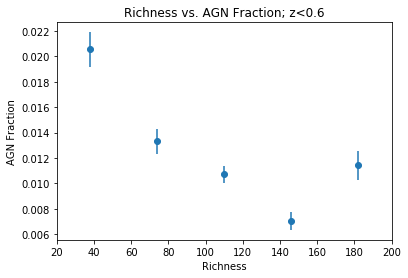

Left Lambda,Right Lambda,AGN Fraction,Number AGN,Number Other,Number Clusters,AGN_Frac_Sigma
float64,float64,float64,int32,int32,int32,float64
20.0,56.0,0.02054004526774751,66,2895,55,0.0013493469690066746
56.0,92.0,0.013308924971551088,39,2570,26,0.0009584809062606043
92.0,128.0,0.010707457785882444,61,5055,34,0.0006818339441982523
128.0,164.0,0.00707330815522454,29,2910,15,0.0007226325418754876
164.0,200.0,0.011433971153141346,10,918,4,0.0011525541033091486


In [6]:
## Begining initialization
startpoint = 20.0
endpoint = 200.0

## Here is where you can change the number of bins
number_of_bins = 5

spacing = (endpoint-startpoint)/number_of_bins
fraction = Table(names=('Left Lambda','Right Lambda','AGN Fraction','Number AGN','Number Other','Number Clusters','AGN_Frac_Sigma'), dtype=('f8','f8','f8','i4','i4','i4','f8'))

## If you want to impose cuts on the data, here is where you would impose them 
h = working_file[working_file['Z']<0.6]

agn = h[h['AGN_Candidate']] #AGN candidates
ee = h[h['AGN_Candidate']!=True] #Everything else

turn = startpoint + spacing

while turn <= endpoint:
    
    ee_turn = ee[ee['LAMBDA_CHISQ']>turn-spacing]
    ee_turn = ee_turn[ee_turn['LAMBDA_CHISQ']<turn]
    
    agn_turn = agn[agn['LAMBDA_CHISQ']>turn-spacing]
    agn_turn = agn_turn[agn_turn['LAMBDA_CHISQ']<turn]
    
    agn_fraction = np.sum(agn_turn['P'])/(np.sum(agn_turn['P'])+np.sum(ee_turn['P']))
    
    ## We assume an error from the standard deviation of a bernouli distrubution
    error_agn = (np.sum(agn_turn['P']*(1-agn_turn['P'])))**(0.5)
    error_all = (np.sum(agn_turn['P']*(1-agn_turn['P']))+np.sum(ee_turn['P']*(1-ee_turn['P'])))**(0.5)
    
    ## Standard error propogation on independent variables (which may not actually be appropriate)
    frac_error = (error_agn**2/(np.sum(agn_turn['P'])+np.sum(ee_turn['P']))**2+(np.sum(agn_turn['P'])*error_all/(np.sum(agn_turn['P'])+np.sum(ee_turn['P']))**2)**2)**(0.5)
    
    fraction.add_row([round(turn-spacing,4),round(turn,4),agn_fraction,len(agn_turn),len(ee_turn),len(unique(ee_turn,keys='MEM_MATCH_ID')),frac_error])
    turn+=spacing
## Plotting stuff
L = (fraction['Left Lambda']+fraction['Right Lambda'])/2.0
errorbar(L,fraction['AGN Fraction'],marker='o',yerr=fraction['AGN_Frac_Sigma'],ls='None')
xlim(startpoint,endpoint)
xlabel('Richness')
ylabel('AGN Fraction')
title('Richness vs. AGN Fraction; z<0.6')
# savefig('Richness_AGN_high.png')
show()
# fraction.write('Richness_AGN_high.csv',overwrite=True)
fraction

### Redshift

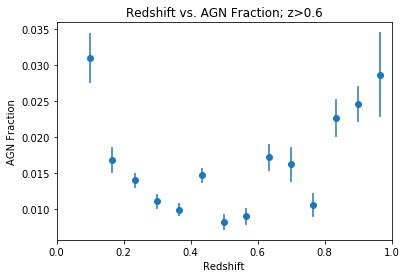

Left Z,Right Z,AGN Fraction,Number AGN,Number Other,Number Clusters,AGN_Frac_Sigma
float64,float64,float64,int32,int32,int32,float64
0.0667,0.1333,0.03093975394214188,18,499,6,0.0035183828486663044
0.1333,0.2,0.016793913258441,17,802,11,0.0017738596047620796
0.2,0.2667,0.013961711062427122,29,1848,20,0.00101522276342537
0.2667,0.3333,0.011070967108100677,27,2122,18,0.0010310264738660764
0.3333,0.4,0.009870904329032298,24,2147,16,0.000887144616680813
0.4,0.4667,0.014669439181411564,37,2397,24,0.0010547519242807507
0.4667,0.5333,0.008185037974895094,23,1927,19,0.0011124381084773288
0.5333,0.6,0.008950484762310395,30,2606,20,0.0011359187289605283
0.6,0.6667,0.017164329600474395,38,1778,15,0.0018730551816501944


In [7]:
## Begining initialization
startpoint = 0.0
endpoint = 1.0

## Here is where you can change the number of bins
number_of_bins = 15

spacing = (endpoint-startpoint)/number_of_bins
fraction = Table(names=('Left Z','Right Z','AGN Fraction','Number AGN','Number Other','Number Clusters','AGN_Frac_Sigma'), dtype=('f8','f8','f8','i4','i4','i4','f8'))

## If you want to impose cuts on the data, here is where you would impose them 
h = working_file

agn = h[h['AGN_Candidate']] #AGN candidates
ee = h[h['AGN_Candidate']!=True] #Everything else

turn = startpoint + spacing

while turn <= endpoint:
    
    ee_turn = ee[ee['Z']>turn-spacing]
    ee_turn = ee_turn[ee_turn['Z']<turn]
    
    # The first class has no values so we don't bother with the analysis for it. 
    if len(ee_turn)==0:
        turn+=spacing
        continue
    
    agn_turn = agn[agn['Z']>turn-spacing]
    agn_turn = agn_turn[agn_turn['Z']<turn]
    
    agn_fraction = np.sum(agn_turn['P'])/(np.sum(agn_turn['P'])+np.sum(ee_turn['P']))
    
    ## We assume an error from the standard deviation of a bernouli distrubution
    error_agn = (np.sum(agn_turn['P']*(1-agn_turn['P'])))**(0.5)
    error_all = (np.sum(agn_turn['P']*(1-agn_turn['P']))+np.sum(ee_turn['P']*(1-ee_turn['P'])))**(0.5)
    
    ## Standard error propogation on independent variables (which may not actually be appropriate)
    frac_error = (error_agn**2/(np.sum(agn_turn['P'])+np.sum(ee_turn['P']))**2+(np.sum(agn_turn['P'])*error_all/(np.sum(agn_turn['P'])+np.sum(ee_turn['P']))**2)**2)**(0.5)
    
    
    fraction.add_row([round(turn-spacing,4),round(turn,4),agn_fraction,len(agn_turn),len(ee_turn),len(unique(ee_turn,keys='MEM_MATCH_ID')),frac_error])
    turn+=spacing
## Plotting stuff
L = (fraction['Left Z']+fraction['Right Z'])/2.0
errorbar(L,fraction['AGN Fraction'],marker='o',yerr=fraction['AGN_Frac_Sigma'],ls='None')
xlim(startpoint,endpoint)
xlabel('Redshift')
ylabel('AGN Fraction')
title('Redshift vs. AGN Fraction; z>0.6')
# savefig('Richness_AGN_high.png')
show()
# fraction.write('Richness_AGN_high.csv',overwrite=True)
fraction